In [3]:
import sys
sys.path.append("../..")

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import scipy, GPy, os, ast
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from gp_growth.storage import mongo
db = mongo.MongoDB()

from gp_growth import factory, testStatistic, normal
from gp_growth.categorical import Categorical
from gp_growth import metric
from gp_growth.data import filter, growth
from gp_growth.storage import searcher

warning in stationary: failed to import cython module: falling back to numpy


RuntimeError: module compiled against API version a but this version of numpy is 9

 /home/ptonner/dev/gp_growth/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning:axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.


In [72]:
import GPy
import scipy
import numpy as np

In [73]:
db = mongo.MongoDB()

In [74]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'),
                                                    (.05, 'white'),
                                                    (.95, 'white'),
                                                    (1, 'red')]
                                        )

In [75]:
import matplotlib.colors as clrs
import matplotlib

In [9]:
bound_cmap = clrs.BoundaryNorm([0,.05,.95,1],3)
bound_cmap.vmax

1

In [10]:
def gpParams(gp):
    ret = {}

    for p in gp.kern.parameters:
        if p.param_array.shape[0] > 1:
    #         print p
            n = p.parameter_names()[0]
            for i in range(p.param_array.shape[0]):
                ret[gp.kern.name+"_"+n+"_"+str(i)] = p.param_array[i]
        else:
            ret[gp.kern.name+"_"+p.parameter_names()[0]] = p[0]
    #         print p
    #         ret[p.name] = p[0]

    for p in gp.likelihood.parameters:
        # need to go deeper
        if isinstance(p,GPy.likelihoods.likelihood.Likelihood):
            for t in p.parameters:
                for ind,n in enumerate(t.parameter_names()):
                    # param_names.append("_".join([gp.likelihood.name,n]))
                    # params.append(p.values[ind])
                    ret["_".join([gp.likelihood.name,p.name,n])] = t.values[ind]
        else:
            for ind,n in enumerate(p.parameter_names()):
                # param_names.append("_".join([gp.likelihood.name,n]))
                # params.append(p.values[ind])
                ret["_".join([gp.likelihood.name,n])] = p.values[ind]

    return ret

In [11]:
colors = sns.hls_palette(n_colors=8,l=.5)
wtColor = 'k'
mutantColor = colors[4]
m1color = colors[-1]#'k'
m2color = colors[3]

colors = sns.color_palette("BuGn_r")
c1 = colors[1]
c2 = colors[2]
mutantColor=c1

# Normal growth 

In [177]:
plates = [u'20150715 PQ 8',
 u'20150607 PQ 4',
 u'20150630 PQ 5',
 u'20150717 PQ 9',
 u'20150514 PQ 2',
 u'20150702 PQ 6',
 u'20150704 PQ 7',
 u'20150517 PQ 3']

## Plot data 

VNG2268 20150715 PQ 8
VNG1179 20150715 PQ 8
trmB 20150715 PQ 8
VNG2614 20150715 PQ 8
VNG0194H 20150607 PQ 4
hlx2 20150607 PQ 4
hrg 20150607 PQ 4
rosR 20150607 PQ 4
sirR 20150630 PQ 5
idr1 20150630 PQ 5
troR 20150630 PQ 5
idr2 20150630 PQ 5
phoR 20150717 PQ 9
VNG0195 20150717 PQ 9
ark 20150717 PQ 9
kinA2 20150717 PQ 9
phoU 20150514 PQ 2
VNG1179 20150514 PQ 2
cspD2 20150514 PQ 2
cspD1 20150514 PQ 2
arcR 20150702 PQ 6
birA 20150702 PQ 6
hlx1 20150702 PQ 6
kaiC 20150702 PQ 6
VNG0471 20150704 PQ 7
VNG1029 20150704 PQ 7
prp2 20150704 PQ 7
VNG0039 20150704 PQ 7
trh2 20150517 PQ 3
trh3 20150517 PQ 3
trh4 20150517 PQ 3
asnC 20150517 PQ 3


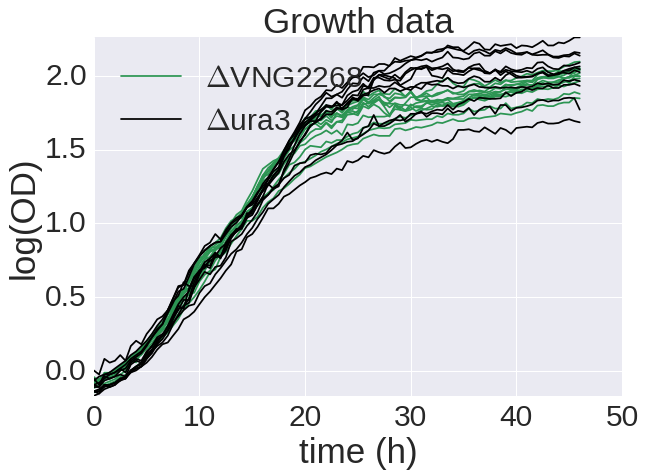

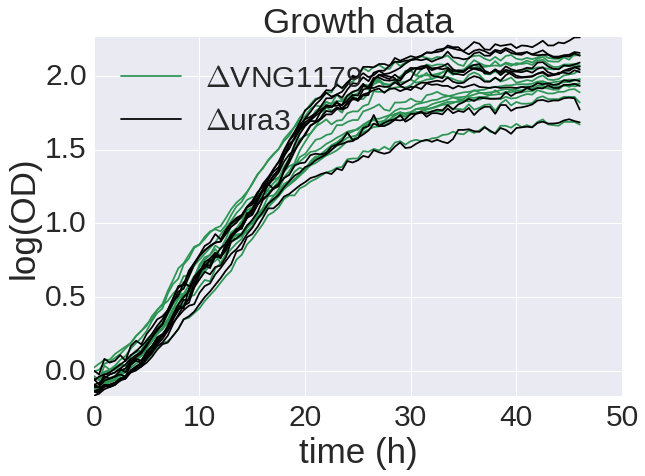

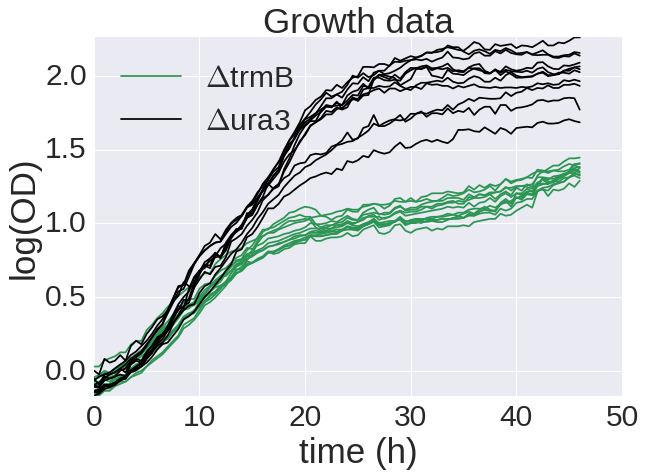

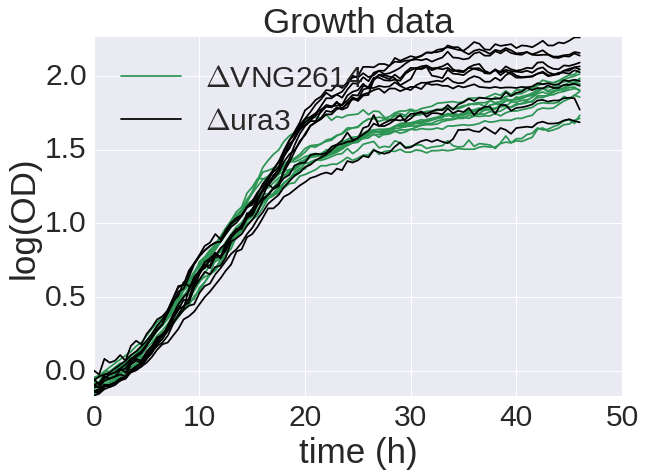

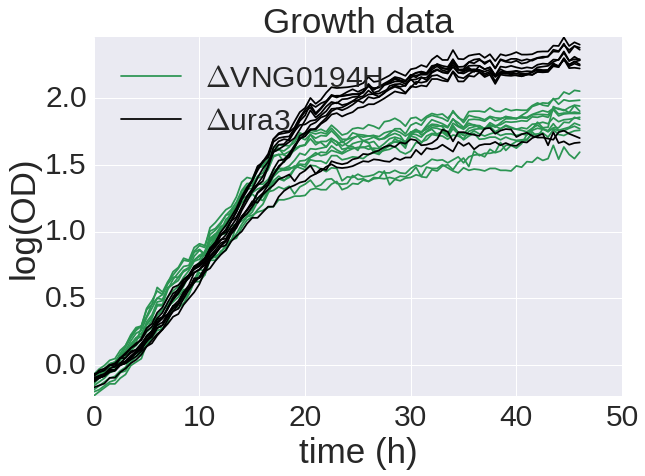

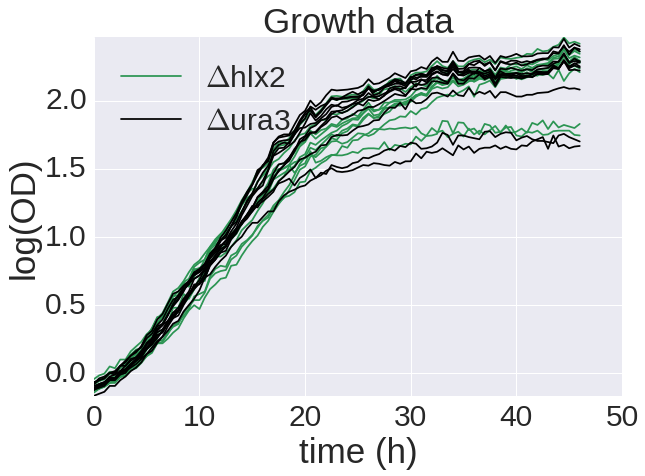

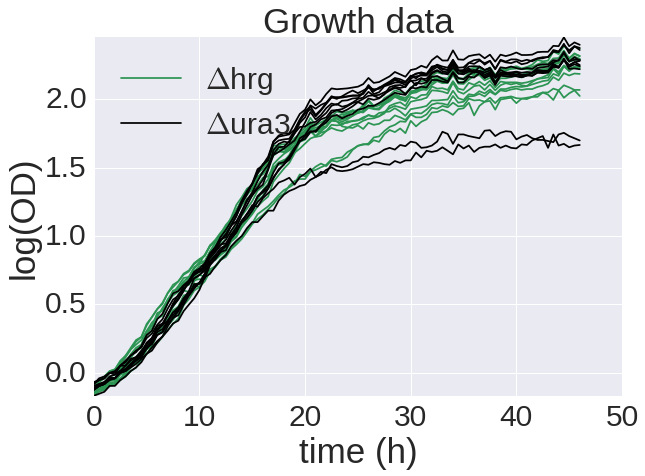

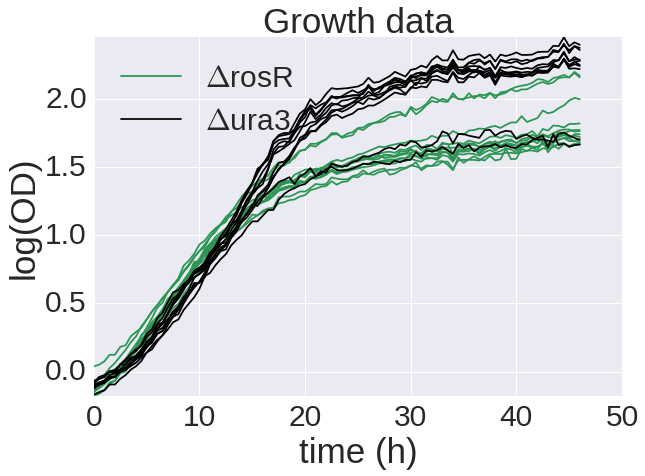

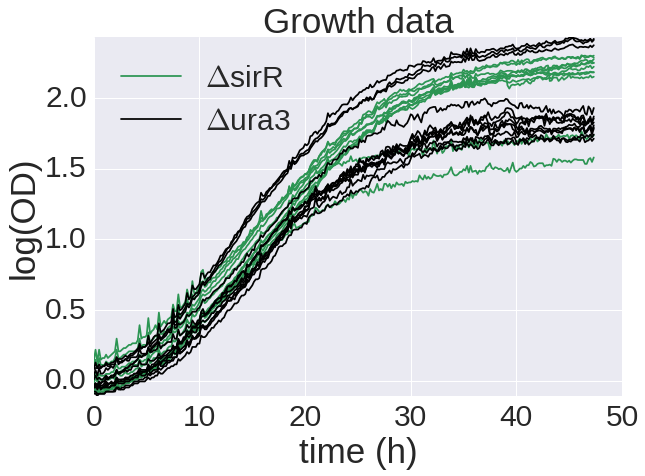

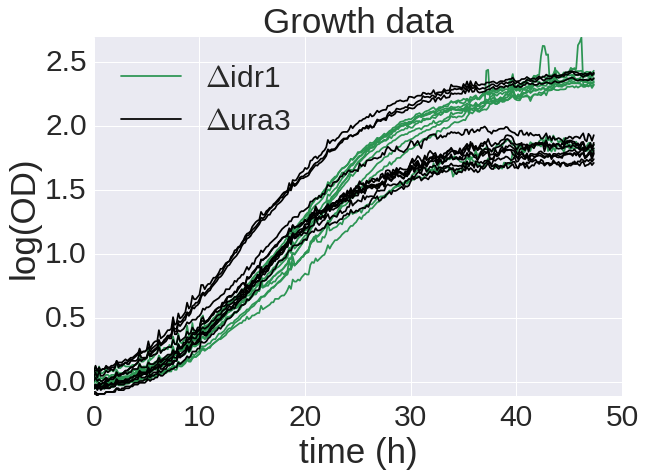

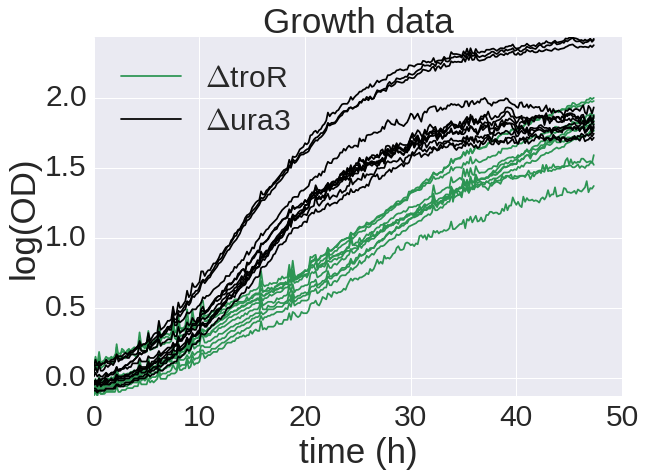

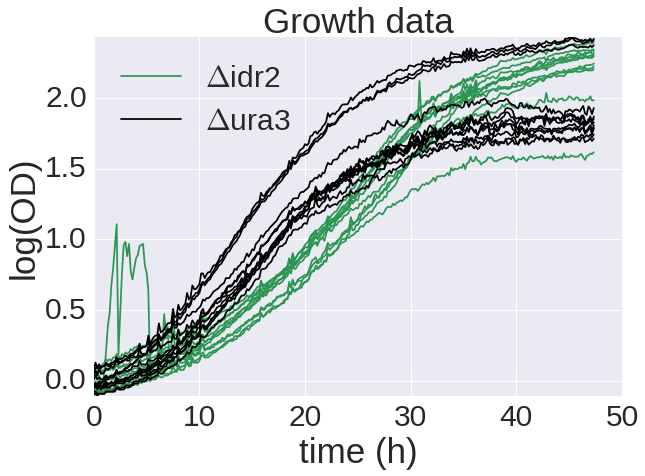

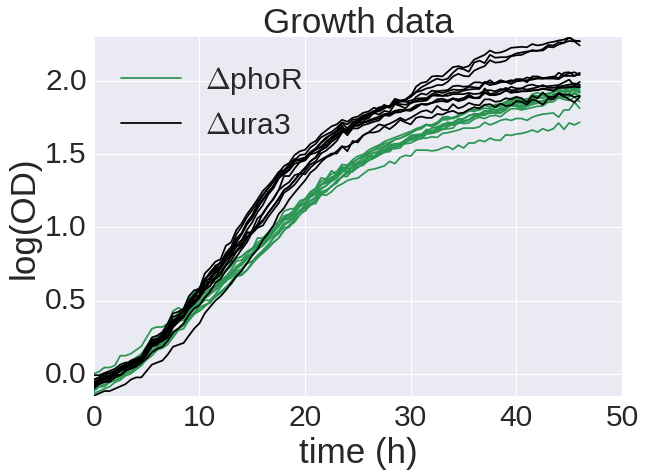

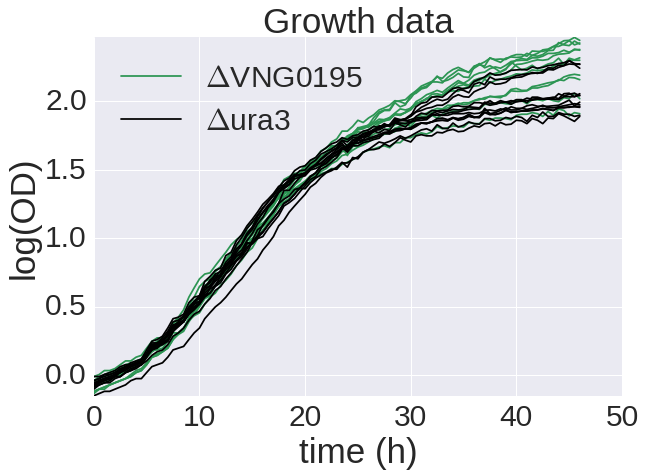

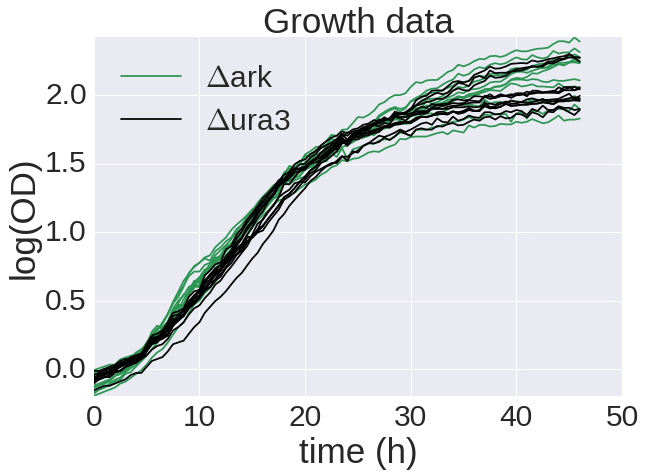

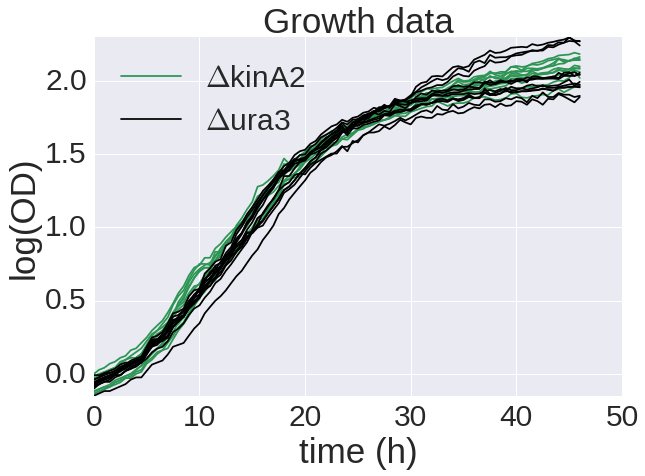

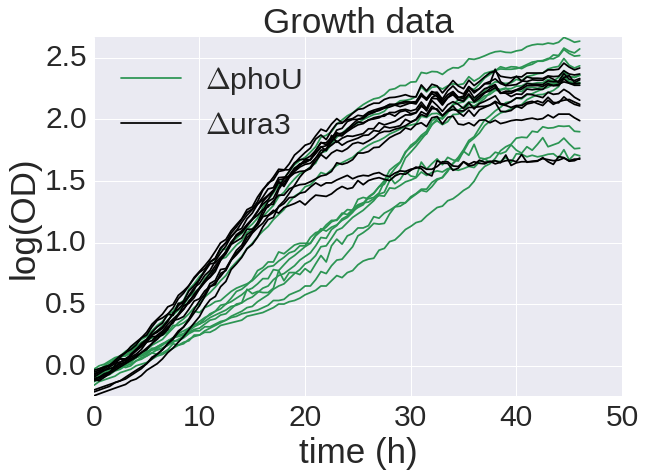

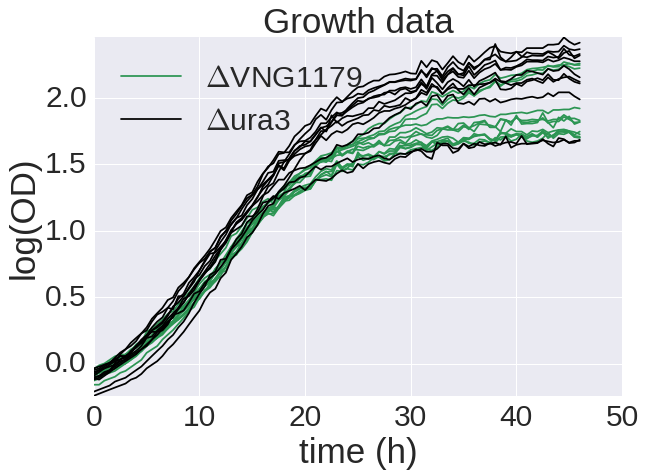

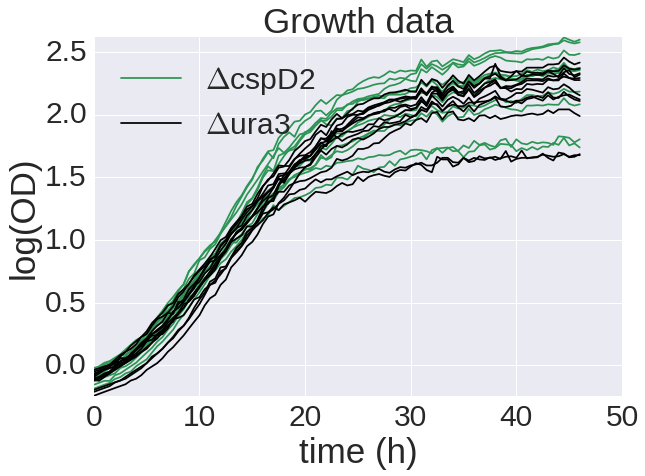

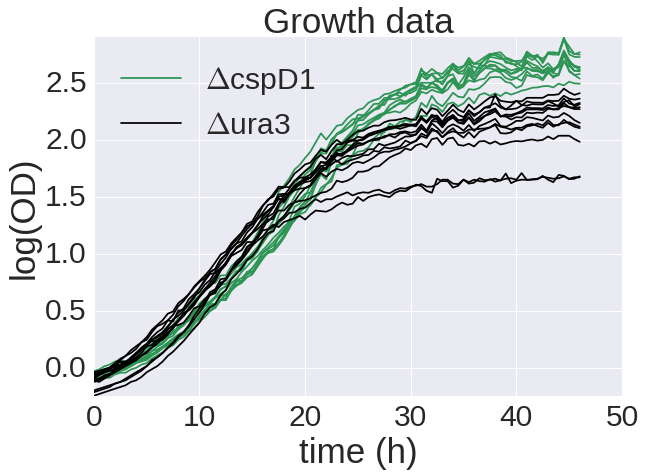

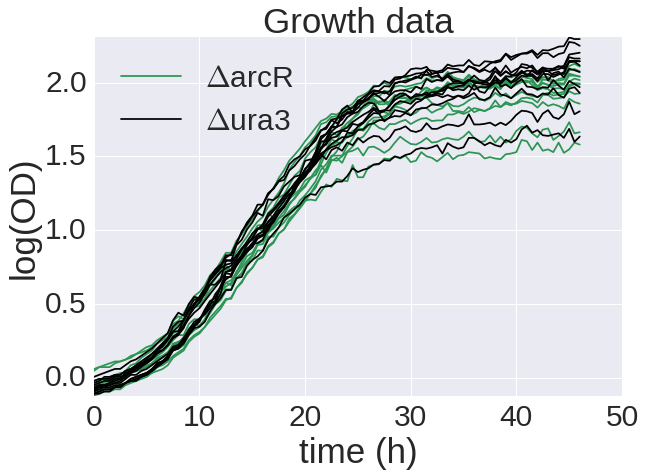

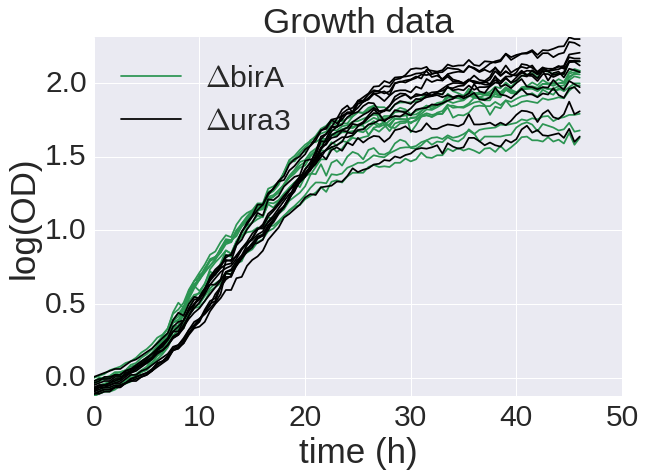

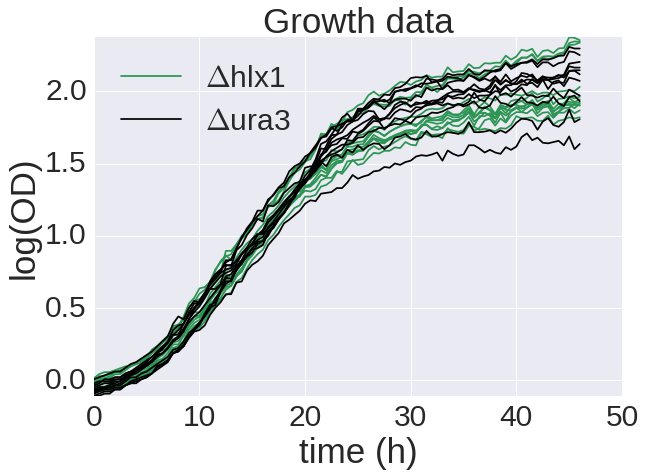

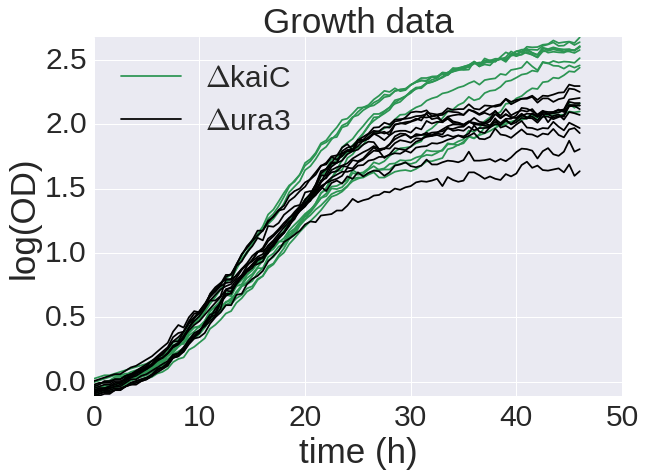

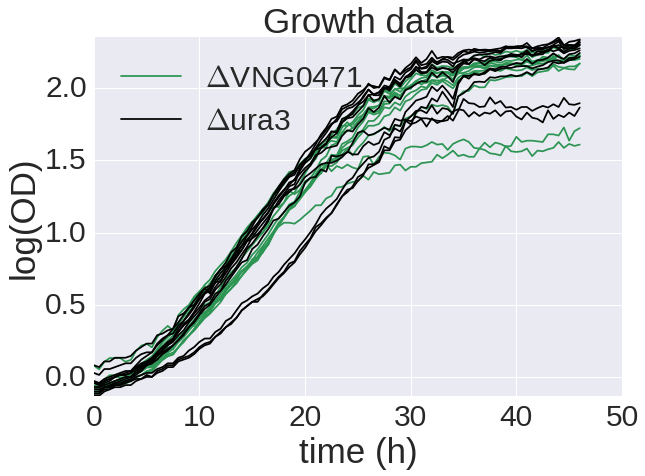

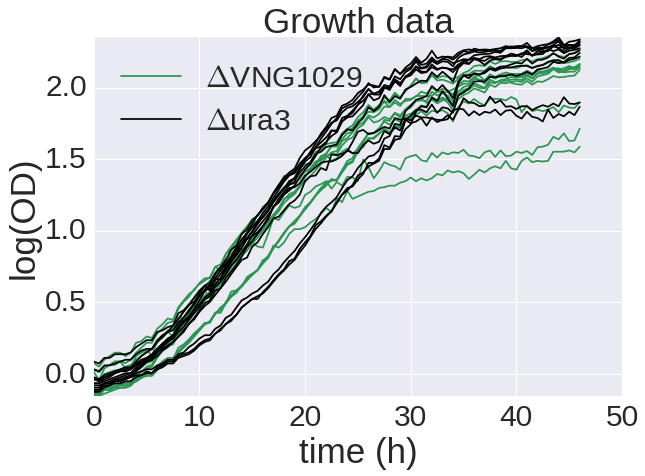

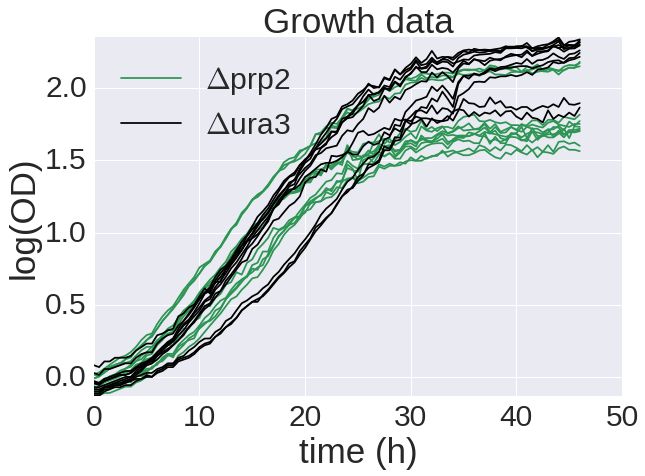

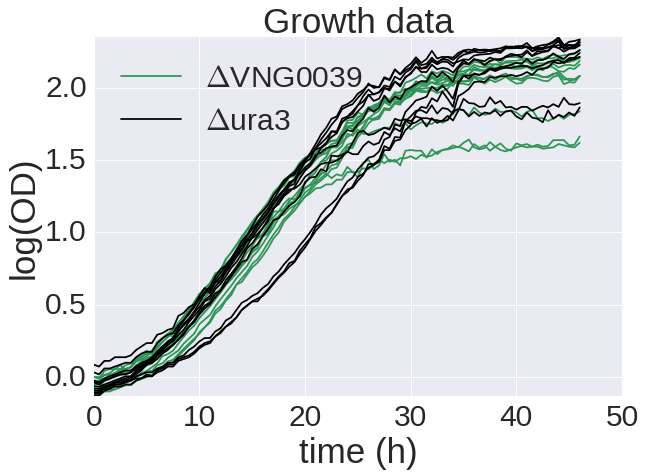

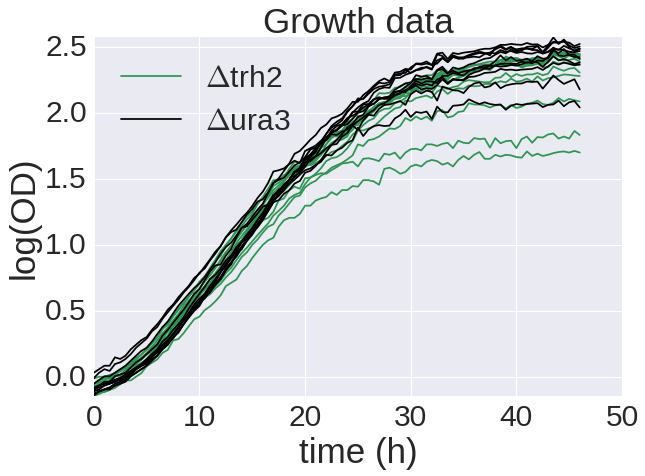

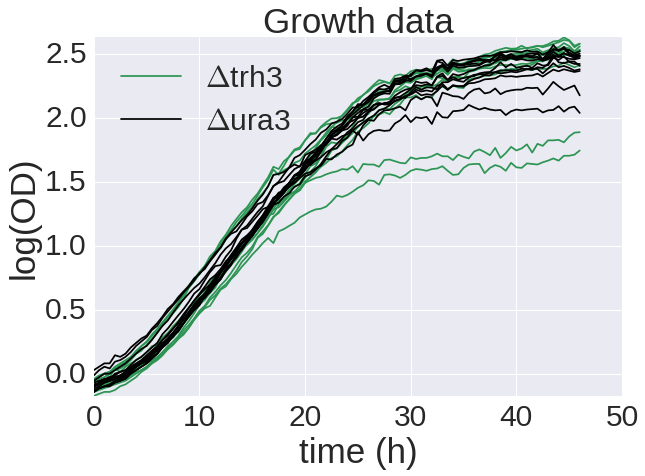

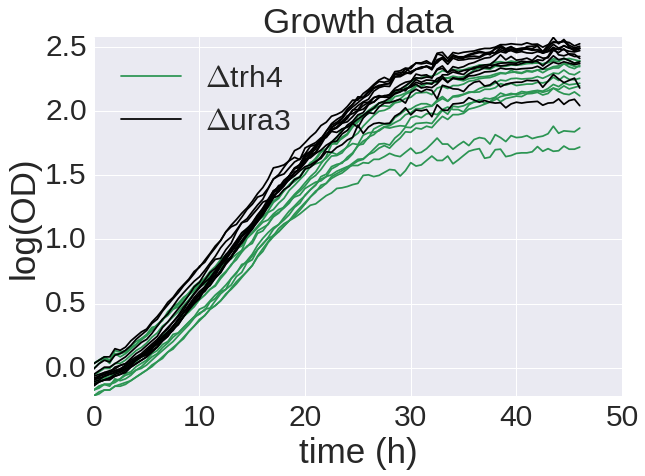

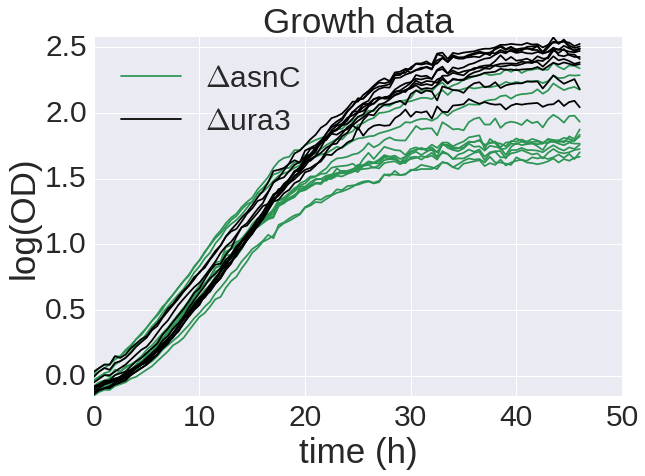

In [179]:
for p in plates:
    strains = db.getExperimentalDesigns("Strain",plate=p)
    for s in strains:
        if s == "ura3" or s == "blank":
            continue
        
        print s,p
        
        data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':0})
        data.data = data.data.iloc[4:,:]
        data.data.time = data.data.time - data.data.time.values[0]
        data.poly_scale(5,10,groupby=["Strain","mM PQ"])
        
        fig,ax = plt.subplots()
        ylim = (data.data.iloc[:,1:].min().min(),data.data.iloc[:,1:].max().max())
        data.key = data.key.sort("Strain",ascending=s < "ura3")
        data.data.iloc[:,1:] = data.data.iloc[:,data.key.index]
        data.plot(groupby=['plate'],colorby="Strain",newFig=False,useAx=ax,title_index=[],colors=[mutantColor,'k'],legend_kwargs={"fontsize":15})
        plt.ylim(ylim)
        plt.ylabel("log(OD)",fontsize=35)
        plt.yticks(fontsize=30)
        ax.set_title("Growth data",fontsize=35)
        plt.xlabel("time (h)",fontsize=35)
        plt.xticks(fontsize=30)
        
        l = plt.legend(loc="upper left",fontsize=30)
        [t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
        
#         plt.grid(False)
#         plt.grid(True,axis="y",color="k",alpha=.4)
        
        plt.savefig("figures/data/normal_"+s+"_"+p+".png",bbox_inches="tight")

In [36]:
reload(testStatistic)
reload(growth)
reload(mongo)
db = mongo.MongoDB()

In [76]:
# t = np.linspace(0,48)
# conf = []
# intConf = []
# labels = []
# bfs = []
# gp_params = pd.DataFrame()
# gp_null_params = pd.DataFrame()

# for p in plates:
#     strains = db.getExperimentalDesigns("Strain",plate=p)
#     for s in strains:
#         if s == "ura3" or s == "blank":
#             continue
        
#         labels.append((s,p))
#         print s,p
        
#         data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':0})
#         data.data = data.data.iloc[4:,:]
#         data.data.time = data.data.time - data.data.time.values[0]
#         data.poly_scale(5,10,groupby=["Strain","mM PQ"])
        
#         ts = testStatistic.TestStatistic(data,normalize=False)
        
#         ts_null = testStatistic.TestStatistic(data)
#         ts_null.inputDimensions = ['time']
#         ts_null.k = 1

#         bfs.append(ts.buildGP().log_likelihood()-ts_null.buildGP().log_likelihood())
        
#         gp_params = gp_params.append(pd.DataFrame(gpParams(ts.buildGP()),index=[s]))
#         gp_null_params = gp_null_params.append(pd.DataFrame(gpParams(ts_null.buildGP()),index=[s]))
        
#         diff = ts.computeFullDifference(t)
#         diff = diff.dot(np.diag(np.ones(diff.n))*ts.std)
        
#         conf.append(ts.computeFullConfidence(t))
#         intConf.append(ts.computeIntegralConfidence(t))
        
#         parent = ts.predict(t,function=False)
#         mutant = ts.predict(t,Strain=0,function=False)

#         parent.plot(color=wtColor,label="$OD_p$",alpha=.4)
#         mutant.plot(color=mutantColor,label="$OD_m$",alpha=.4)
#         plt.xlabel("time (h)",fontsize=20)
#         plt.xticks(fontsize=20)
#         plt.ylabel("$OD$",fontsize=25)
#         plt.yticks(fontsize=20)
#         plt.legend(loc="best",fontsize=25)
#         plt.title("Growth Prediction",fontsize=25)
#         plt.savefig("figures/growthPrediction_normal_"+s+"_"+p+".png",bbox_inches="tight")
#         plt.close()
        
        
#         diff.plot(t[1:],color=mutantColor,alpha=.4)
#         plt.plot([t.min(),t.max()],[0,0],'k',linewidth=3)
#         plt.xlabel("time (h)",fontsize=25)
#         plt.xticks(fontsize=20)
#         plt.ylabel("$OD_m - OD_p$",fontsize=25)
#         plt.yticks(fontsize=20)
#         plt.title("Function Difference",fontsize=25)
#         plt.savefig("figures/functionDiff_normal_"+s+"_"+p+".png",bbox_inches="tight")
#         plt.close()


# conf = np.array(conf)
# intConf = np.array(intConf)
# bfs = np.array(bfs)
# labels = pd.DataFrame(labels,columns=['Strain','plate'])

In [180]:
strains = ['sirR','idr1','idr2','rosR','trmB','VNG1179','asnC']

In [181]:
plates = [db.plates.find_one(db.getExperimentalDesigns("plate",Strain=s,plate=plates)[0])['name'] for s in strains]
plates

[u'20150630 PQ 5',
 u'20150630 PQ 5',
 u'20150630 PQ 5',
 u'20150607 PQ 4',
 u'20150715 PQ 8',
 u'20150715 PQ 8',
 u'20150517 PQ 3']

In [182]:
t = np.linspace(0,48)
conf = []
intConf = []
labels = []
bfs = []
gp_params = pd.DataFrame()
gp_null_params = pd.DataFrame()

for p,s in zip(plates,strains):
    
    print s,p

    data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':0})
    data.data = data.data.iloc[4:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(5,10,groupby=["Strain","mM PQ"])

    ts = testStatistic.TestStatistic(data,normalize=False)

    ts_null = testStatistic.TestStatistic(data)
    ts_null.inputDimensions = ['time']
    ts_null.k = 1

    bfs.append(ts.buildGP().log_likelihood()-ts_null.buildGP().log_likelihood())

    gp_params = gp_params.append(pd.DataFrame(gpParams(ts.buildGP()),index=[s]))
    gp_null_params = gp_null_params.append(pd.DataFrame(gpParams(ts_null.buildGP()),index=[s]))

    diff = ts.computeFullDifference(t)
    diff = diff.dot(np.diag(np.ones(diff.n))*ts.std)

    conf.append(ts.computeFullConfidence(t))
    intConf.append(ts.computeIntegralConfidence(t))

    parent = ts.predict(t,function=False)
    mutant = ts.predict(t,Strain=0,function=False)

    parent.plot(color=wtColor,label="$OD_p$",alpha=.4)
    mutant.plot(color=mutantColor,label="$OD_m$",alpha=.4)
    plt.xlabel("time (h)",fontsize=35)
    plt.xticks(fontsize=30)
    plt.ylabel("$OD$",fontsize=35)
    plt.yticks(fontsize=30)
    plt.legend(loc="best",fontsize=30)
    plt.title("Growth Prediction",fontsize=35)
    plt.savefig("figures/growthPrediction_normal_"+s+"_"+p+".png",bbox_inches="tight")
    plt.close()


    diff.plot(t[1:],color=mutantColor,alpha=.4)
    plt.plot([t.min(),t.max()],[0,0],'k',linewidth=3)
    plt.xlabel("time (h)",fontsize=35)
    plt.xticks(fontsize=30)
    plt.ylabel("$OD_m - OD_p$",fontsize=35)
    plt.yticks(fontsize=30)
    plt.title("Function Difference",fontsize=35)
    plt.savefig("figures/functionDiff_normal_"+s+"_"+p+".png",bbox_inches="tight")
    plt.close()

conf = np.array(conf)
intConf = np.array(intConf)
bfs = np.array(bfs)
# labels = pd.DataFrame(labels,columns=['Strain','plate'])

sirR 20150630 PQ 5
idr1 20150630 PQ 5
idr2 20150630 PQ 5
rosR 20150607 PQ 4
trmB 20150715 PQ 8
VNG1179 20150715 PQ 8
asnC 20150517 PQ 3


In [183]:
gp_params.to_csv("normalGrowth_gpParams.csv")
gp_null_params.to_csv("normalGrowth_gpParams_null.csv")

In [184]:
bak = conf.copy()
conf[np.isnan(conf)] = .5

# thresh = np.any((conf > .95,conf < .05),0)*conf
thresh = np.where(conf < .05,-1,np.where(conf>.95,1,0))

NameError: name 'yl' is not defined

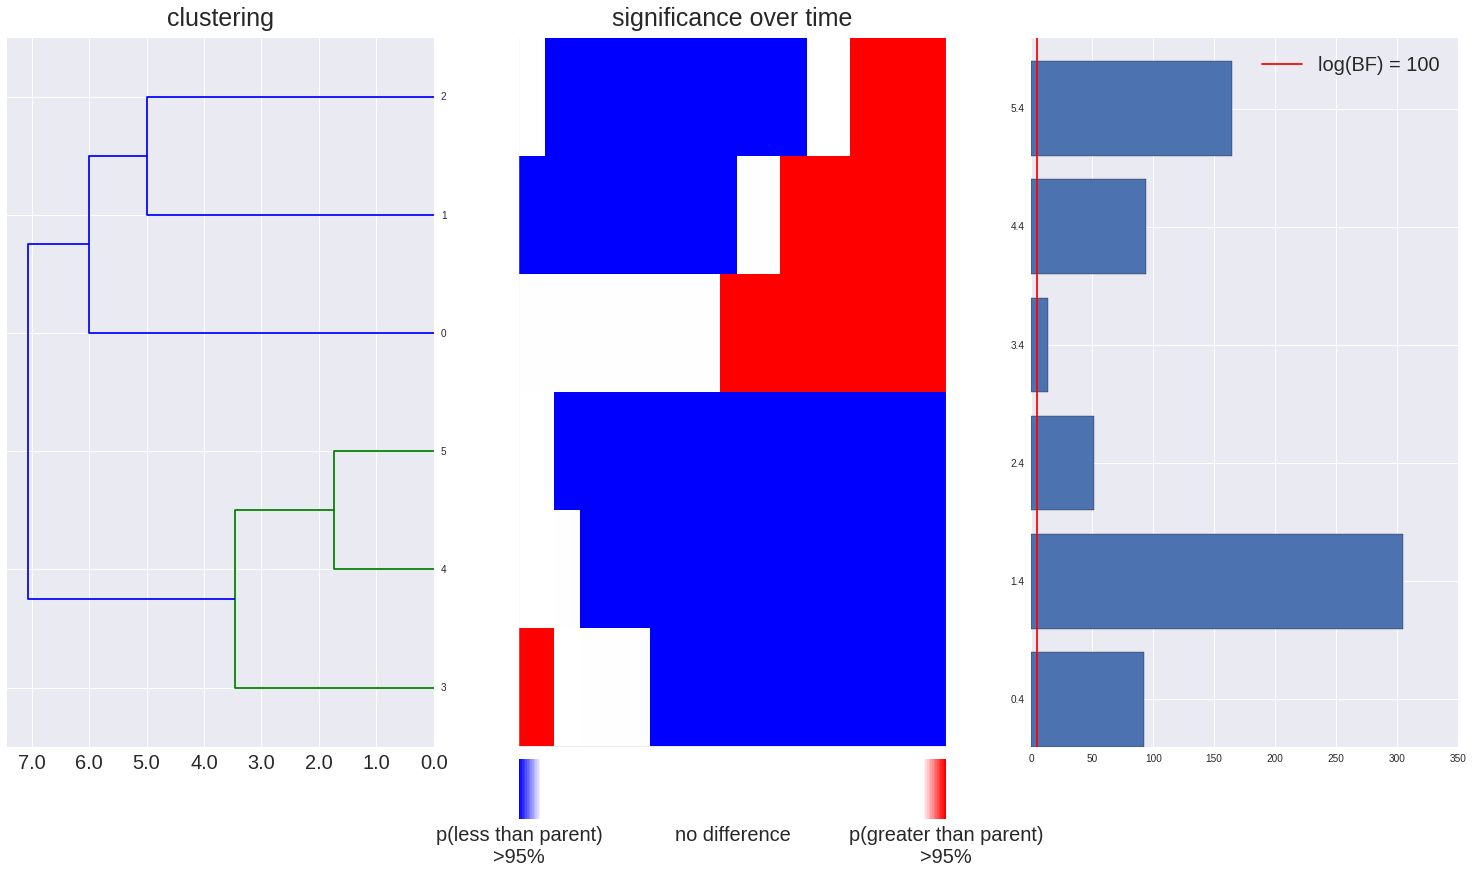

In [81]:
plt.figure(figsize=(26,14))
aspect = 10

ax1 = plt.subplot2grid((aspect+1,3), (0,0), colspan=1, rowspan=aspect)
ax2 = plt.subplot2grid((aspect+1,3), (0,1), colspan=1, rowspan=aspect)
# ax3 = plt.subplot2grid((aspect+1,4), (0,2), colspan=1, rowspan=aspect)
ax4 = plt.subplot2grid((aspect+1,3), (0,2), colspan=1, rowspan=aspect)
cbarAx = plt.subplot2grid((aspect+1,3), (aspect,1), colspan=1, rowspan=2)

# plt.subplot(131)
z = scipy.cluster.hierarchy.linkage(thresh)
ret = scipy.cluster.hierarchy.dendrogram(z,orientation="right",ax=ax1);
yt = ax1.get_yticks()
ax1.set_yticks(yt)
# yl = ["$\Delta "+ l +'$' for l in labels.loc[ret['leaves'],"Strain"].tolist()]
# ax1.set_yticklabels(yl,fontsize=20)
ax1.set_xticklabels(ax1.get_xticks().astype(str),fontsize=20)
ax1.set_title("clustering",fontsize=25,y=1.01)

# plt.subplot(132)
im = ax2.imshow(1-thresh[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top")
# im = ax2.imshow(1-conf[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top",vmin=.05,vmax=.95)
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("significance over time",fontsize=25,y=1.01)
# ax2.set_frame_on(True)

# cbar = plt.colorbar(im,ticks=[0,.5,1],orientation="horizontal",ax=cbarAx)
# cbar.ax.set_xticklabels(['less than parent', 'no difference', 'greater than parent'],fontsize=20)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbarAx, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticks=[0,.5,1])
cb1.ax.set_xticklabels(['p(less than parent)\n>95%', 'no difference', 'p(greater than parent)\n>95%'],fontsize=20)

# ax3.barh(range(intConf.shape[0]),1-intConf[ret['leaves']]-.5)
# ax3.plot([-.45,-.45],[0,intConf.shape[0]],'r')
# ax3.plot([.45,.45],[0,intConf.shape[0]],'r')

# ax3.set_ylim(0,intConf.shape[0])
# ax3.set_yticks(np.arange(intConf.shape[0])+.4)
# ax3.set_yticklabels(yl,fontsize=20)
# ax3.set_title("total significance",fontsize=25)

ax4.barh(range(bfs.shape[0]),bfs[ret['leaves']])
ax4.plot([np.log(100),np.log(100)],[0,intConf.shape[0]],'r',label="log(BF) = 100")
# ax4.plot([np.log(10),np.log(10)],[0,intConf.shape[0]],'y')
ax4.legend(loc="best",fontsize=20)

ax4.set_ylim(0,bfs.shape[0])
ax4.set_yticks(np.arange(bfs.shape[0])+.4)
ax4.set_yticklabels(yl,fontsize=20)
ax4.set_title("log(BF)",fontsize=25,y=1.01)
ax4.set_xticklabels(ax4.get_xticks().astype(int).astype(str),fontsize=20)

plt.tight_layout(pad=2.0)
plt.savefig("figures/funcDiff_normal.png",bbox_inches="tight",dpi=300)

## Permutation correction

In [186]:
table = pd.read_csv("standard_bayesFactors.csv")

bfsPermuted = {}
for i,r in table.iterrows():
    bfsPermuted[(r.Strain,r.plate)] = np.array(ast.literal_eval(r.PermutedValues))

In [ ]:
t = np.linspace(5,48)
numPerm = 100

# bfsPermuted = {}

for p in plates:
    strains = db.getExperimentalDesigns("Strain",plate=p)
    for s in strains:
        if s == "ura3" or s == "blank":
            continue
            
        print s,p
        
        if not (s,p) in bfsPermuted:
            bfsPermuted[(s,p)] = []
        
        data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':0})
        data.data.time = data.data.time - data.data.time.values[0]
        data.poly_scale(5,10,groupby=["Strain","mM PQ"])
        
        strainOrig = data.key.Strain.copy()
        
        orders = []
        
        for i in range(len(bfsPermuted[(s,p)]),numPerm):
            
            if i%10 == 0:
                print i
        
            order = np.random.choice(range(data.key.shape[0]),data.key.shape[0],replace=False)
            orders.append(order)
            
            data.key.Strain = data.key.Strain[order].values

            ts = testStatistic.TestStatistic(data)
            ts_null = testStatistic.TestStatistic(data)
            ts_null.inputDimensions = ['time']
            ts_null.k = 1

            bfsPermuted[(s,p)].append(ts.buildGP().log_likelihood()-ts_null.buildGP().log_likelihood())
            
            data.key.Strain = strainOrig

sirR 20150630 PQ 5
idr1 20150630 PQ 5
troR 20150630 PQ 5
idr2 20150630 PQ 5
sirR 20150630 PQ 5
idr1 20150630 PQ 5
troR 20150630 PQ 5
idr2 20150630 PQ 5
sirR 20150630 PQ 5
idr1 20150630 PQ 5
troR 20150630 PQ 5
idr2 20150630 PQ 5
VNG0194H 20150607 PQ 4
hlx2 20150607 PQ 4
hrg 20150607 PQ 4
rosR 20150607 PQ 4
VNG2268 20150715 PQ 8
VNG1179 20150715 PQ 8
trmB 20150715 PQ 8
VNG2614 20150715 PQ 8
VNG2268 20150715 PQ 8
VNG1179 20150715 PQ 8
trmB 20150715 PQ 8
VNG2614 20150715 PQ 8
trh2 20150517 PQ 3
60

In [205]:
columns = ["Strain",'plate','BayesFactor','FDR','PermutedValues']
table = pd.DataFrame(columns=columns)

for ind,tup in labels.iterrows():
    strain,plate = tup
    
    bf = bfs[ind]
    permBFs = bfsPermuted[(strain,plate)]
    fdr = 1.*np.sum(bfsPermuted[(strain,plate)] > bf)/bfsPermuted[(strain,plate)].shape[0]
    row = pd.DataFrame([[strain,plate,bf,fdr,permBFs.tolist()]],columns=columns)
    table = pd.concat((table,row))
    
table.to_csv("standard_bayesFactors.csv",index=False)

(-1, 28)

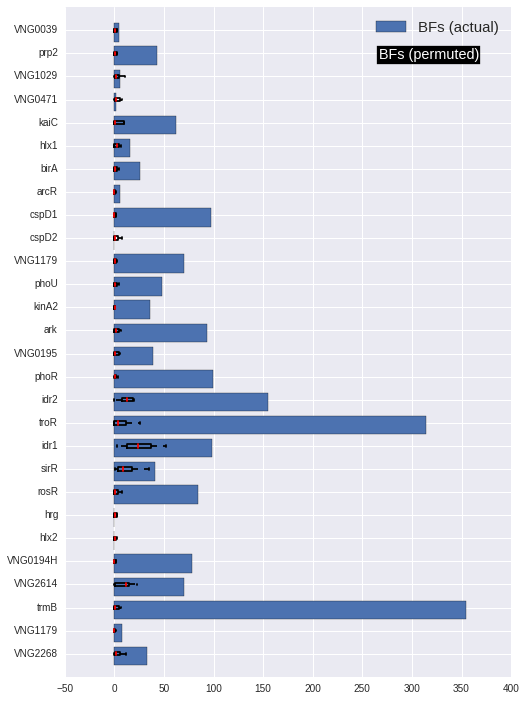

In [141]:
plt.figure(figsize=(8,12))

# plt.plot(bfs,range(28))
plt.barh(np.arange(28)-.5,bfs,label="BFs (actual)")

for i,r in labels.iterrows():
    s,p = r
    plt.boxplot(bfsPermuted[(s,p)],vert=False,positions=[i],boxprops={'color':'k'},whiskerprops={'color':'k'})
    
plt.yticks(range(28),labels.Strain.tolist())

plt.legend(loc="upper right",fontsize=15)

plt.figtext(0.67, 0.84, 'BFs (permuted)',
            backgroundcolor='k',
            color='white', weight='roman', size='x-large')
    
plt.ylim(-1,28)

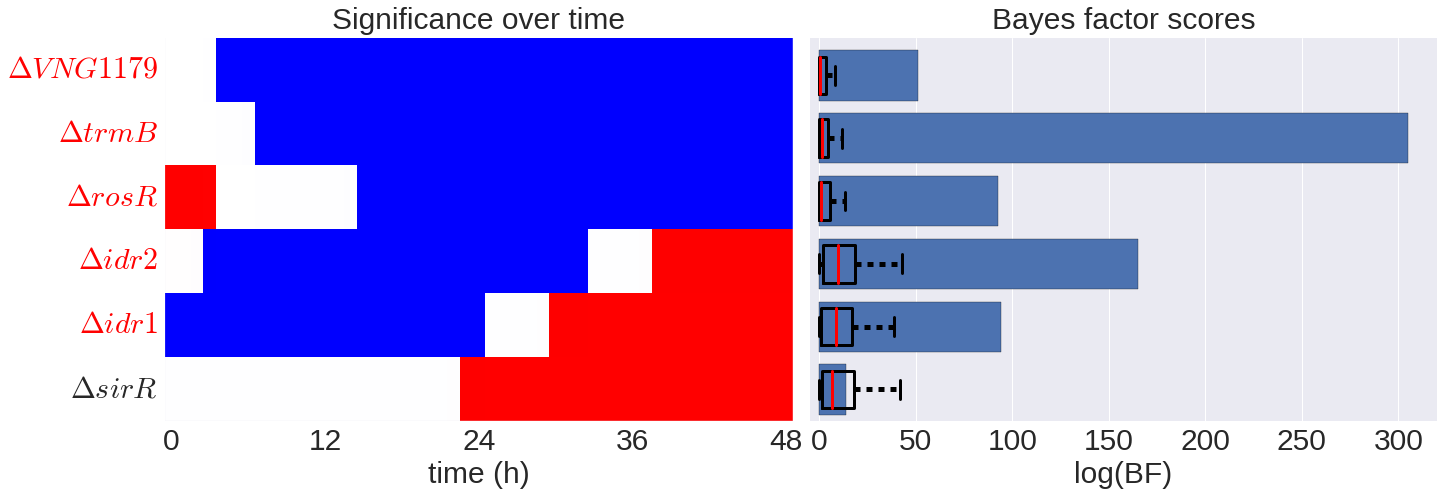

In [167]:
plt.figure(figsize=(20,6))
aspect = 50

# ax1 = plt.subplot2grid((aspect+1,3), (0,0), colspan=1, rowspan=aspect)
ax2 = plt.subplot2grid((aspect+1,2), (0,0), colspan=1, rowspan=aspect)
# ax3 = plt.subplot2grid((aspect+1,4), (0,2), colspan=1, rowspan=aspect)
ax4 = plt.subplot2grid((aspect+1,2), (0,1), colspan=1, rowspan=aspect)
# cbarAx = plt.subplot2grid((aspect+1,2), (aspect,0), colspan=1, rowspan=1)

im = ax2.imshow(1-thresh,cmap=cmap,interpolation="none",aspect="auto",origin="top")
ax2.grid(False)
t = np.linspace(0,48,5,dtype=int)
ax2.set_xticks(t)
ax2.set_xticklabels(ax2.get_xticks().astype(str),fontsize=30)
ax2.set_xlabel("time (h)",fontsize=30)
ax2.set_title("Significance over time",fontsize=30,y=1.01)
yl = ["$\Delta "+ l +'$' for l in strains]
ax2.set_yticks(range(6))
ax2.set_yticklabels(yl,fontsize=30)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbarAx, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticks=[0,.5,1])
cb1.ax.set_xticklabels(['p(less than parent)\n>95%', 'no difference', 'p(greater than parent)\n>95%'],fontsize=30)


ax4.barh(np.arange(bfs.shape[0]),bfs,label="BFs (actual)")


# for h,i in enumerate(ret['leaves']):
#     s,p = labels.iloc[i,:].values
for i,v in enumerate(zip(strains,plates)):
    s,p = v
    ax4.boxplot(bfsPermuted[(s,p)],vert=False,positions=[i+.4],widths=[.6],boxprops={'color':'k','linewidth':3},whiskerprops={'color':'k','linewidth':5},capprops={'linewidth':3},medianprops={'linewidth':3})
    

yl = ax2.get_yticklabels()
for i,t in enumerate(yl):
    s,p = zip(strains,plates)[i]
    if np.sum(bfs[i] > bfsPermuted[(s,p)])>bfsPermuted[(s,p)].shape[0]*.9:
        t.set_color('r')

# ax4.legend(loc="best",fontsize=25)

# ax4.text(292, 25, 'BFs (permuted)',
#             backgroundcolor='k',
#             color='white', weight='roman', size=25)

ax4.set_ylim(-.1,bfs.shape[0])
ax4.set_yticks([])
ax4.set_title("Bayes factor scores",fontsize=30,y=1.01)
ax4.set_xticklabels(ax4.get_xticks().astype(int).astype(str),fontsize=30)
ax4.set_xlabel("log(BF)",fontsize=30)
ax4.set_xlim(-5,bfs.max()+15)

plt.tight_layout(pad=.5)
plt.savefig("figures/standard_testStatistic.png",bbox_inches="tight",dpi=150)

In [137]:
conf.shape

(6, 49)

AttributeError: 'list' object has no attribute 'loc'

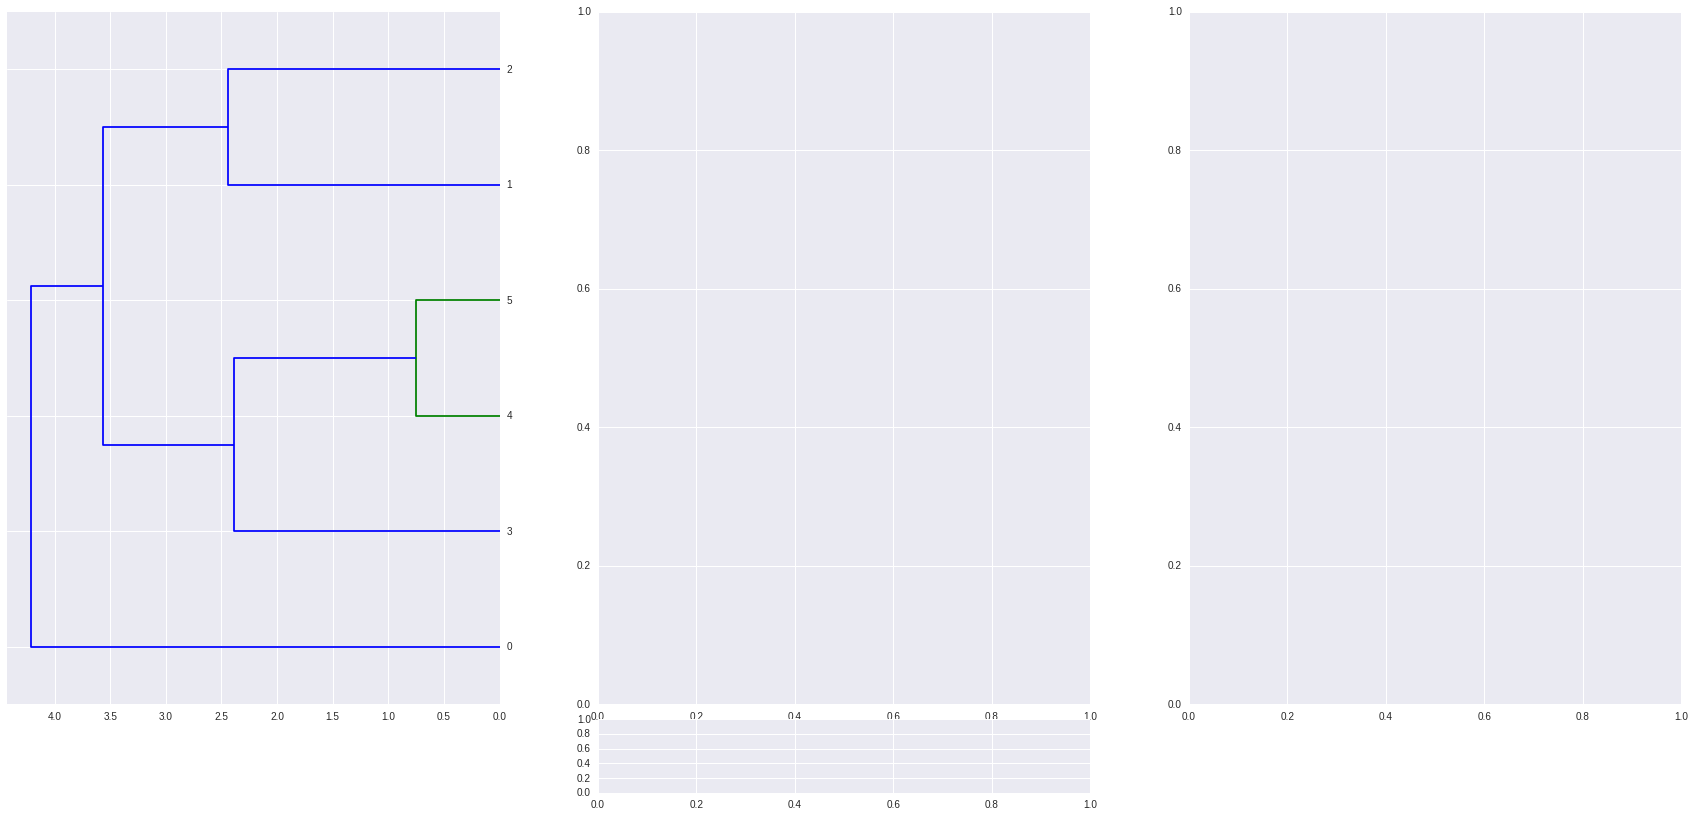

In [83]:
plt.figure(figsize=(30,14))
aspect = 8

ax1 = plt.subplot2grid((aspect+1,3), (0,0), colspan=1, rowspan=aspect)
ax2 = plt.subplot2grid((aspect+1,3), (0,1), colspan=1, rowspan=aspect)
# ax3 = plt.subplot2grid((aspect+1,4), (0,2), colspan=1, rowspan=aspect)
ax4 = plt.subplot2grid((aspect+1,3), (0,2), colspan=1, rowspan=aspect)
cbarAx = plt.subplot2grid((aspect+1,3), (aspect,1), colspan=1, rowspan=2)

# plt.subplot(131)
# z = scipy.cluster.hierarchy.linkage(thresh)
z = scipy.cluster.hierarchy.linkage(conf)
ret = scipy.cluster.hierarchy.dendrogram(z,orientation="right",ax=ax1,color_threshold=2.3);
yt = ax1.get_yticks()
ax1.set_yticks(yt)
yl = ["$\Delta "+ l +'$' for l in labels.loc[ret['leaves'],"Strain"].tolist()]
ax1.set_yticklabels(yl,fontsize=30)
ax1.set_xticklabels(ax1.get_xticks().astype(str),fontsize=30)
ax1.set_title("Hierarchical clustering",fontsize=30,y=1.01)
ax1.set_xlabel("distance (Euclidean)",fontsize=30)

# plt.subplot(132)
im = ax2.imshow(1-thresh[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top")
ax2.grid(False)
t = np.linspace(0,48,5,dtype=int)
ax2.set_xticks(t)
ax2.set_xticklabels(ax2.get_xticks().astype(str),fontsize=30)
ax2.set_xlabel("time (h)",fontsize=30)
ax2.set_yticks([])
ax2.set_title("Significance over time",fontsize=30,y=1.01)
# ax2.set_frame_on(True)

# cbar = plt.colorbar(im,ticks=[0,.5,1],orientation="horizontal",ax=cbarAx)
# cbar.ax.set_xticklabels(['less than parent', 'no difference', 'greater than parent'],fontsize=20)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbarAx, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticks=[0,.5,1])
cb1.ax.set_xticklabels(['p(less than parent)\n>95%', 'no difference', 'p(greater than parent)\n>95%'],fontsize=30)

# ax3.barh(range(intConf.shape[0]),1-intConf[ret['leaves']]-.5)
# ax3.plot([-.45,-.45],[0,intConf.shape[0]],'r')
# ax3.plot([.45,.45],[0,intConf.shape[0]],'r')

# ax3.set_ylim(0,intConf.shape[0])
# ax3.set_yticks(np.arange(intConf.shape[0])+.4)
# ax3.set_yticklabels(yl,fontsize=20)
# ax3.set_title("total significance",fontsize=25)

# ax4.barh(range(bfs.shape[0]),bfs[ret['leaves']])
# ax4.plot([np.log(100),np.log(100)],[0,intConf.shape[0]],'r',label="log(BF) = 100")
# ax4.plot([np.log(10),np.log(10)],[0,intConf.shape[0]],'y')

ax4.barh(np.arange(bfs.shape[0]),bfs[ret['leaves']],label="BFs (actual)")

# for i,r in labels.iterrows():
for h,i in enumerate(ret['leaves']):
    s,p = labels.iloc[i,:].values
    ax4.boxplot(bfsPermuted[(s,p)],vert=False,positions=[h+.5],boxprops={'color':'k'},whiskerprops={'color':'k'})
    
ax4.legend(loc="best",fontsize=25)

ax4.text(292, 25, 'BFs (permuted)',
            backgroundcolor='k',
            color='white', weight='roman', size=25)

ax4.set_ylim(0,bfs.shape[0])
ax4.set_xlim(-5,bfs.max()+5)
ax4.set_yticks(np.arange(bfs.shape[0])+.4)
ax4.set_yticklabels(yl,fontsize=30)


# set significant labels to red
yl = ax4.get_yticklabels()
for i,t in enumerate(yl):
    s,p = labels.iloc[ret['leaves'][i],:].values
    if np.sum(bfs[ret['leaves'][i]] > bfsPermuted[(s,p)])>bfsPermuted[(s,p)].shape[0]*.9:
        t.set_color('r')

yl = ax1.get_yticklabels()
for i,t in enumerate(yl):
    s,p = labels.iloc[ret['leaves'][i],:].values
    if np.sum(bfs[ret['leaves'][i]] > bfsPermuted[(s,p)])>bfsPermuted[(s,p)].shape[0]*.9:
        t.set_color('r')
        
ax4.set_title("Bayes factor scores",fontsize=30,y=1.01)
ax4.set_xticklabels(ax4.get_xticks().astype(int).astype(str),fontsize=30)
ax4.set_xlabel("log(BF)",fontsize=30)

plt.tight_layout(pad=.5)
plt.savefig("figures/funcDiff_normal.png",bbox_inches="tight",dpi=150)

###  generate tex code for supplement

In [131]:
def tex_string(p,s):

    return r"""\begin{subfigure}[b]{.32\linewidth}
    \centering
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/normal_%s_%s.png}
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/growthPrediction_normal_%s_%s.png}
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/functionDiff_normal_%s_%s.png}
        \caption{}
\end{subfigure}
"""% (s,p,s,p,s,p)

In [132]:
ret = ''
for p in plates:
    strains = db.getExperimentalDesigns("Strain",plate=p)
    for s in strains:
        if s == "ura3" or s == "blank":
            continue
            
        ret += tex_string(p,s)
        
print ret

\begin{subfigure}[b]{.32\linewidth}
    \centering
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/normal_VNG2268_20150715 PQ 8.png}
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/growthPrediction_normal_VNG2268_20150715 PQ 8.png}
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/functionDiff_normal_VNG2268_20150715 PQ 8.png}
        \caption{}
\end{subfigure}
\begin{subfigure}[b]{.32\linewidth}
    \centering
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/normal_VNG1179_20150715 PQ 8.png}
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/growthPrediction_normal_VNG1179_20150715 PQ 8.png}
        \includegraphics[width=.32\linewidth]{figures/supplement/standard/functionDiff_normal_VNG1179_20150715 PQ 8.png}
        \caption{}
\end{subfigure}
\begin{subfigure}[b]{.32\linewidth}
    \centering
        \includegraphics[width=.32\linewidth]{figures/supplement/stan